# 3. Radiative backpropagation pipeline

## Overview

Hello RB pipeline!

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Use Radiative Backpropagation Python integrators</li>
  <li>Optimize cool stuff</li>
</ul>
    
</div>


### Step 1 - setup

We start by importing an AD variant of Mitsuba. We then load and traverse the scene to be able to access its parameters later.

In [2]:
# Add mitsuba and drjit to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../build/python')

In [3]:
from matplotlib import pyplot as plt
import drjit as dr
import mitsuba as mi
mi.set_variant('cuda_ad_rgb')

In [4]:
def show_image(img, title):
    plt.imshow(mi.util.convert_to_bitmap(img)); plt.axis('off'); plt.title(title);

scene = mi.load_file('../scenes/cbox.xml', res=128, spp=16)

max_depth = 4
prb_integrator = mi.load_dict({
    'type': 'prb',
    'max_depth': max_depth
})
path_integrator = mi.load_dict({
    'type': 'path',
    'max_depth': max_depth
})

2022-02-14 16:39:08 INFO main [xml.cpp:1260] Loading XML file "../scenes/cbox.xml" with variant "cuda_ad_rgb"..

2022-02-14 16:39:08 INFO main [Scene] Building scene in OptiX ..

2022-02-14 16:39:08 INFO main [Scene] OptiX ready. (took 36ms)

2022-02-14 16:39:08 INFO main [xml.cpp:1319] Done loading XML file "../scenes/cbox.xml" (took 54ms).

### Step 2 - primal rendering

We first perform a primal rendering step without AD

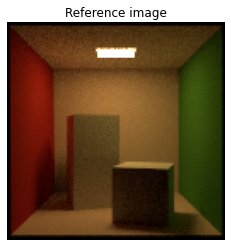

In [5]:
integrator = scene.integrator()
image_ref = prb_integrator.render(scene, seed=0, spp=128)
show_image(image_ref, 'Reference image')

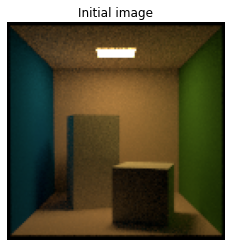

In [7]:
params = mi.traverse(scene)

# Update scene parameter
key = 'redwall.bsdf.reflectance.value'
params.keep([key])
param_ref = mi.Color3f(params[key])
params[key] = mi.Color3f(0.01, 0.2, 0.9)
params.update()

# Render initial image
image = prb_integrator.render(scene, seed=0, spp=128)
show_image(image, 'Initial image')

### Step 3 - Loss image

We need to define an objective function and compute the gradients of the result of that function with respect to the output image of the primal rendering step. This will give us a *loss image* where every pixel is the gradient of the corresponding primal pixel value w.r.t. the objective function.

In this simple tutorial, the objective function will be the MSE with regards to the reference image.

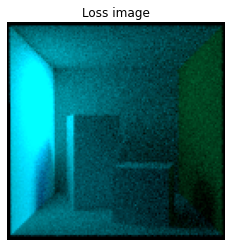

In [8]:
def compute_image_loss(image, obj_func):
    dr.enable_grad(image)
    ob_val = obj_func(image)
    dr.backward(ob_val)
    image_loss = dr.grad(image)
    dr.set_grad(image, 0.0)
    return image_loss

def MSE(img):
    return dr.hsum_async(dr.sqr(img - image_ref)) / len(img)

image_adj = compute_image_loss(image, MSE)

show_image(image_adj * 1e6, 'Loss image')

### Step 4 - Radiative Backpropagation

The image loss needs to be backpropagated throught the light transport simulation to the scene parameters.
Instead of relying on automatic differentiation, we will this time use a Radiative Backpropagation integrator to propagate the image loss gradient values.

In [9]:
dr.enable_grad(params)
prb_integrator.render_backward(scene, params, image_adj, seed=0)
grad_backward = dr.grad(params[key])

### Forward AD rendering with regular path tracer

2022-02-14 16:39:34 INFO main [SamplingIntegrator] Starting render job (128x128, 128 samples)

2022-02-14 16:39:35 INFO main [SamplingIntegrator] Rendering finished. (took 948ms)

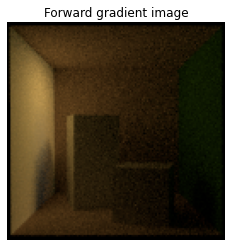

In [10]:
dr.set_grad(params[key], 0.0)
dr.enable_grad(params[key])
dr.set_flag(dr.JitFlag.LoopRecord, False)
image = path_integrator.render(scene, seed=0, spp=128)
dr.forward(params[key])

grad_forward = dr.grad(image)

show_image(grad_forward, "Forward gradient image")

In [11]:
print(f"grad_backward: {dr.hsum(grad_backward)[0]}")
print(f"grad_forward:  {dr.dot(grad_forward.array, image_adj.array)}")

grad_backward: -0.0031133482698351145
grad_forward:  -0.0031184451654553413


### *Reference API*

- [<code>mitsuba.core.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.load_file)